<a href="https://colab.research.google.com/github/surekhag28/ComputerVision/blob/main/tmp/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  0%|          | 98304/26421880 [00:00<00:27, 971368.67it/s]

cuda:0


26427392it [00:00, 83060210.94it/s]                             


Extracting F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 602142.18it/s]
 20%|██        | 892928/4422102 [00:00<00:00, 8696749.02it/s]

Extracting F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:00, 30515718.52it/s]                           
8192it [00:00, 202135.13it/s]


Extracting F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz
Extracting F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
Epoch: 0/20..  Training Loss: 0.538..  Validation Loss: 0.385..  Training Accuracy:  80.026..  Validation Accuracy: 84.902
Epoch: 1/20..  Training Loss: 0.383..  Validation Loss: 0.329..  Training Accuracy:  85.793..  Validation Accuracy: 88.145
Epoch: 2/20..  Training Loss: 0.340..  Validation Loss: 0.298..  Training Accuracy:  87.341..  Validation Accuracy: 88.828
Epoch: 3/20..  Training Loss: 0.315..  Validation Loss: 0.279..  Training Accuracy:  88.394..  Validation Accuracy: 88.438
Epoch: 4/20..  Training Loss: 0.296..  Validation Loss: 0.288..  Training Accuracy:  88.946..  Validation Accuracy: 89.629
Epoch: 5/20..  Training Loss: 0.285..  Validation Loss: 0.293..  Training Accuracy:  89.601..  Validation Accuracy: 89.883
Epoch: 6/20..  Training Loss: 0.276..  Validation Loss: 0.266..  Training Accuracy:  89.766..  Validation Ac

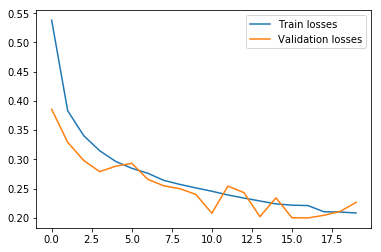

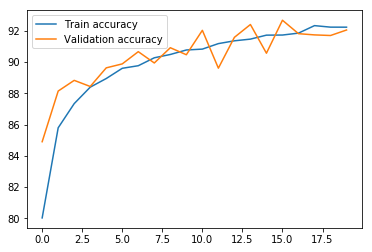

Test Accuracy of the model on the 10000 test images: 91.3 %


In [ ]:

import numpy as np
import torch
from torch.utils.data import sampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import numpy as np

num_epochs = 20
NUM_TRAIN = 59000

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dev)

transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(28, padding=4),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],std=[0.5])
                            ])

test_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],std=[0.5])
                            ])

train_data = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
                                         sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

fashionMnist_val = datasets.FashionMNIST('F_MNIST_data/', train=True, download=True, transform=test_transform)
val_loader = torch.utils.data.DataLoader(fashionMnist_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 60000)))


# Download and load the test data
test_data = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)



class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride =1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = 2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size = 2, stride=2))
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

model = CNN()
model = model.to(dev)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

total_step = len(train_loader)
train_losses, val_losses, train_accs, val_accs = [],[],[],[]

for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0
    train_acc = 0
    val_acc = 0
    for images,labels in train_loader:
        images = images.to(dev)
        labels = labels.to(dev)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        train_acc += float(correct) / float(total)
    else:
        with torch.no_grad():
            model.eval()
            for images,labels in val_loader:
                images = images.to(dev)
                labels = labels.to(dev)

                val_out = model(images)
                loss = criterion(val_out, labels)
                val_loss += loss.item()

                total = labels.size(0)
                _, predicted = torch.max(val_out.data, 1)
                correct = (predicted == labels).sum().item()
                val_acc += float(correct) / float(total)
        model.train()

    print("Epoch: {}/{}.. ".format(epoch, num_epochs),
              "Training Loss: {:.3f}.. ".format(train_loss/len(train_loader)),
              "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader)),
              "Training Accuracy: {: .3f}.. ".format(train_acc/len(train_loader)*100),
              "Validation Accuracy: {:.3f}".format(val_acc/len(val_loader)*100))

    train_losses.append(train_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    train_accs.append(train_acc/len(train_loader)*100)
    val_accs.append(val_acc/len(val_loader)*100)

plt.figure()           
plt.plot(train_losses,label = "Train losses")
plt.plot(val_losses, label = "Validation losses")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accs,label = "Train accuracy")
plt.plot(val_accs, label = "Validation accuracy")
plt.legend() 
plt.show()   


model.eval()  

with torch.no_grad():
    correct = 0
    total = 0
  for images, labels in test_loader:
          images = images.to(dev)
          labels = labels.to(dev)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))
